In [1]:
import os
import random as r
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as  pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("mps")    # cuda, mps, cpu...

In [6]:
class ABMDataset(Dataset):
    def __init__(self, ntypes, directory="csvs", rotate=None):
        # read directory to get simulation CSVs
        csvs = []
        for file in os.listdir(directory):
            if file.startswith("adhesion"):
                if file.split("_")[1] == "1" or file.split("_")[1] == "10":
                    csvs.append(file)
        n = len(csvs)

        # size of discrete (image) input
        image_shape = np.array([ntypes, 64, 64], dtype=int)

        # to generate more samples we can rotate the input multiple times
        if rotate is None:
            rotate = 1
        
        # create holders for all samples (increase size if rotating input)
        self.data = torch.zeros(rotate*n, *image_shape)
        self.labels = torch.zeros(rotate*n, 1, dtype=int)

        # additionally hold original agent values
        self.locations = torch.zeros(rotate*n, 1000, 2)
        self.states = torch.zeros(rotate*n, 1000, dtype=int)

        # go through each file
        for i in range(n):
            # read CSV
            agents = np.genfromtxt(f"{directory}/{csvs[i]}", delimiter=',', skip_header=True)

            # get positions/states for all agents
            positions = agents[:, 0:2] - 250    # center points
            states = agents[:, 9].astype(int)

            # rotate across all angles
            for j in range(rotate):
                # get rotation matrix
                theta = r.uniform(0,6.28)
                M = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta), np.cos(theta)]])
                rotated = positions @ M + 175  # apply rotation and un-center points

                self.locations[rotate*i + j] = torch.tensor(rotated) 
                self.states[rotate*i + j] = torch.tensor(states)

                # embed agents into discrete space (image)
                for k in range(len(agents)):
                    discrete = (64 * rotated[k] / 350).astype(int)
                    self.data[rotate*i + j][states[k], discrete[0], discrete[1]] += 1

                # get label from file name
                self.labels[rotate*i + j, 0] = int(csvs[i].split("_")[1])
            
        # send to device
        self.data = self.data.to(device)
        self.labels = self.labels.to(device)
        
    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [7]:
dataset = ABMDataset(ntypes=2, rotate=20)
print(len(dataset))

2000


In [8]:
batch = 128
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, shuffle=True)

In [9]:
class VAE(nn.Module):
    def __init__(self, h_dim=2048, z_dim=32):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU()
        )
        
        self.fc_mu = nn.Linear(h_dim, z_dim)
        self.fc_var = nn.Linear(h_dim, z_dim)
        self.f = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, out_channels=2, kernel_size=3, padding=1)
        )
        
    def encode(self, input):
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return result, mu, log_var

    def decode(self, z):
        result = self.f(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        gen, mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

In [10]:
def loss_fn(generated, original, mu, logvar, beta):
    BCE = F.mse_loss(generated, original, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta * KLD

In [11]:
vae = VAE().to(device)
optimizer = torch.optim.AdamW(vae.parameters(), lr=1e-3)

In [31]:
# send to device and turn on training
vae.train()

beta = 0.1

# training vae
epochs = 1000
for epoch in range(epochs):
    for idx, (original, _) in enumerate(train_loader):
        # run through vae and measure loss with MSE
        generated, mu, logvar = vae(original)
        loss = loss_fn(generated, original, mu, logvar, beta)

        # update vae
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss/len(generated)):.3f}")

Epoch[1/1000] Loss: 496.389
Epoch[2/1000] Loss: 496.534
Epoch[3/1000] Loss: 503.924
Epoch[4/1000] Loss: 501.538
Epoch[5/1000] Loss: 495.664
Epoch[6/1000] Loss: 501.623
Epoch[7/1000] Loss: 497.347
Epoch[8/1000] Loss: 505.111
Epoch[9/1000] Loss: 496.781
Epoch[10/1000] Loss: 508.799
Epoch[11/1000] Loss: 496.208
Epoch[12/1000] Loss: 499.363
Epoch[13/1000] Loss: 485.366
Epoch[14/1000] Loss: 501.168
Epoch[15/1000] Loss: 511.226
Epoch[16/1000] Loss: 489.754
Epoch[17/1000] Loss: 502.599
Epoch[18/1000] Loss: 500.220
Epoch[19/1000] Loss: 493.237
Epoch[20/1000] Loss: 495.202
Epoch[21/1000] Loss: 494.979
Epoch[22/1000] Loss: 490.206
Epoch[23/1000] Loss: 517.390
Epoch[24/1000] Loss: 499.378
Epoch[25/1000] Loss: 501.358
Epoch[26/1000] Loss: 493.011
Epoch[27/1000] Loss: 518.428
Epoch[28/1000] Loss: 504.979
Epoch[29/1000] Loss: 498.501
Epoch[30/1000] Loss: 501.865
Epoch[31/1000] Loss: 506.492
Epoch[32/1000] Loss: 498.343
Epoch[33/1000] Loss: 494.728
Epoch[34/1000] Loss: 498.526
Epoch[35/1000] Loss: 50

In [ ]:
# torch.save(vae.state_dict(), "vae.pt")

In [ ]:
vae = VAE().to(device)
vae.load_state_dict(torch.load("vae_16.pt"))

In [13]:
def make_image(locations, states):
    # create blank image
    image = np.zeros((2000, 2000, 3), dtype=np.uint8)

    indices = np.random.permutation(len(locations))
    
    # go through all agents and draw on image
    for i in indices:
        # get color of agent
        if states[i] == 0:
            color = (255, 0, 0)
        else:
            color = (0, 255, 255)

        # get xy coordinates
        x, y = int(5.714 * locations[i,0]), int(5.714 * locations[i,1])
        
        # draw the agent and a black outline to distinguish overlapping agents
        image = cv2.ellipse(image, (x, y), (24, 24), 0, 0, 360, color, -1)
        image = cv2.ellipse(image, (x, y), (24, 24), 0, 0, 360, (0, 0, 0), 1)

    # flip to match origin on bottom-left
    image = cv2.flip(image, 0)

    return image

In [32]:
# pick an example
index = -1

# get original image and locations/states to compare
orig = dataset.data[index].unsqueeze(0)
orig_locations = dataset.locations[index]
orig_states = dataset.states[index]

# re-create image and send to cpu
vae.eval()
gen = vae(orig)[0]
gen = gen.to("cpu").detach()[0]


# round generated to nearest integer
gen[gen < 0] = 0
gen = torch.round(gen).to(int)
gen_n = torch.sum(gen)

# create tensors to hold generated output agents
gen_locations = torch.zeros(gen_n, 3)
gen_states = torch.zeros(gen_n)

# hold count of agents and iterate through generated array
offset = 2
count = 0
radius = 0   # small nudge away from center of discretized position
for i in range(gen.shape[0]):
    for j in range(gen.shape[1]):
        for k in range(gen.shape[2]):
            for l in range(int(gen[i,j,k])):
                theta = 360 * r.uniform(0,1)
                gen_locations[count,0] = j * 5.46 + radius * math.cos(theta) + offset
                gen_locations[count,1] = k * 5.46 + radius * math.sin(theta) + offset
                gen_states[count] = i
                count += 1

# save images for original and generated
cv2.imwrite("orig.png", make_image(orig_locations, orig_states))
cv2.imwrite("gen.png", make_image(gen_locations, gen_states))

#
locs = gen_locations.numpy()
stas = gen_states.numpy()
np.save("locations.npy", locs)
np.save("states.npy", stas)
print(np.sum(stas == 0))
print(np.sum(stas == 1))

400
425


In [34]:
# split data for evalulating parameter predictor
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch = 128
train_loader_pred = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_loader_pred = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=True)

In [113]:
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
        )

    def forward(self, x):
        return self.network(x)

In [114]:
model = Predictor().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [1]:
# set to eval to get embedding
vae.eval()
vae.requires_grad = False

# train parameter predictor
epochs = 200
for epoch in range(epochs):
    for idx, (original, labels) in enumerate(train_loader_pred):
        # run through trained VAE model
        generated, mu, logvar = vae(original)
        merge = torch.cat((mu, logvar), axis=1)

        # predict the parameter and compute loss
        predicted = model(merge)
        loss = torch.sum((predicted - labels)**2) / len(original)
        
        # update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch[{epoch+1}/{epochs}] Loss: {(loss):.3f}")

NameError: name 'vae' is not defined

In [ ]:
# torch.save(model.state_dict(), "model.pt")

In [ ]:
# model = Predictor().to(device)
# model.load_state_dict(torch.load("model.pt"))

In [116]:
# set to eval
vae.eval()
model.eval()

# create holder for true/predicted
n = len(dataset)
compare = torch.zeros(3, n)

# get true parameter values
compare[0] = torch.flatten(dataset.labels.to("cpu").detach())

# get predicted parameter values
generated, mu, logvar = vae(dataset.data)
merge = torch.cat((mu, logvar), axis=1)
compare[1] = torch.flatten(model(merge).to("cpu").detach())

# indicate if from test or train
compare[2][train_dataset.indices] = 0
compare[2][test_dataset.indices] = 1

# create dataframe for plotting with seaborn
df = pd.DataFrame(compare.numpy().T)
df.columns =["expect", "predict", "dataset"]
df["expect"] = df["expect"].astype(int)

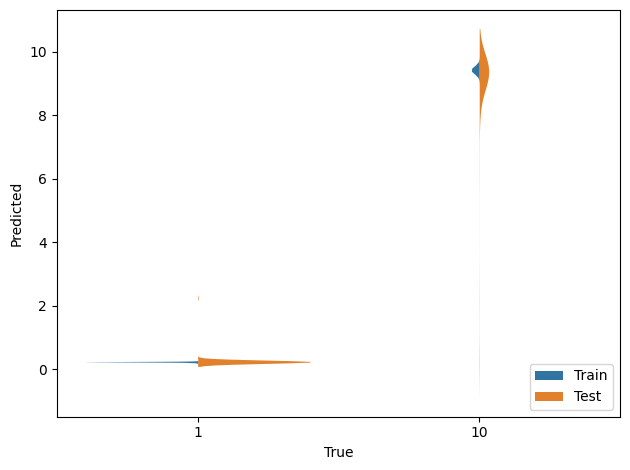

In [117]:
## number of parameter classes
groups = 10

# create figure
fig, ax = plt.subplots()

# make violin plot for test and train
sns.violinplot(data=df,
               x="expect",
               y="predict",
               hue="dataset",
               split=True,
               inner=None,
               linewidth=0)

# add labels
plt.legend(labels=["Train", "Test"], loc="lower right")
# plt.plot([0, groups-1], [1, groups], "k--")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.tight_layout()
plt.savefig("plot.png")
plt.show()

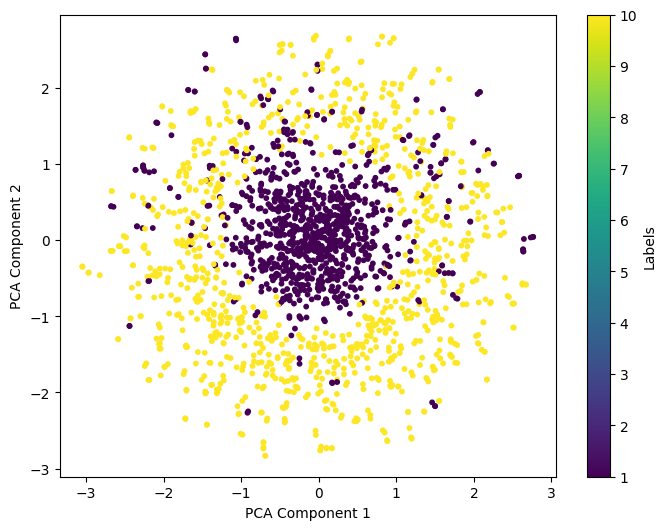

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap.umap_ as umap


# Initialize an empty list to store latent space representations and labels
latent_space_representations = []
latent_space_labels = []

# Set VAE model to evaluation mode
vae.eval()

# Iterate over batches in train loader
for idx, (original, labels) in enumerate(train_loader):
    # Forward pass through VAE to obtain latent space representations
    with torch.no_grad():
        _, mu, logvar = vae.encode(original.to(device))
    
    # Append mu and labels to the respective lists
    latent_space_representations.append(mu.cpu().numpy())
    latent_space_labels.append(labels.cpu().numpy())

# Concatenate or aggregate latent space representations from all batches
latent_space_array = np.concatenate(latent_space_representations, axis=0)
latent_space_labels_array = np.concatenate(latent_space_labels, axis=0)

scaler = StandardScaler()
latent_space_array = scaler.fit_transform(latent_space_array)

# Apply PCA to reduce dimensionality to 2 dimensions
pca = TSNE(n_components=2, perplexity=500)
# pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space_array)

# Visualize the PCA of the latent space with colors according to labels
plt.figure(figsize=(8, 6))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=latent_space_labels_array, cmap='viridis', s=10)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Labels')
plt.show()